In [1]:
import imp
import utils.compare as uc
import utils.statistics as us
import json
train_prefix = '/mnt/intel/artifact_management/plusai_2d_dataset/revised/front/train/images/'
test_prefix = '/mnt/intel/artifact_management/plusai_2d_dataset/revised/front/benchmark/images/'

label_path = '/mnt/intel/jupyterhub/hong.zhong/data/plus/kpdet_train_v1.16_20221227.json'
with open(label_path, 'r') as f:
    gt_data = json.load(f)

label_path = '/mnt/intel/jupyterhub/hong.zhong/data/plus/kpdet_eval_v1.16.json'
with open(label_path, 'r') as f:
    gt_test_data = json.load(f)

label_path = '/mnt/intel/jupyterhub/hong.zhong/data/plus/noise_mine/dataset_inference_all_boxes.json'
with open(label_path, 'r') as f:
    pred_data = json.load(f)

label_path = '/mnt/intel/jupyterhub/hong.zhong/data/plus/noise_mine/val_dataset_inference_all_boxes.json'
with open(label_path, 'r') as f:
    pred_test_data = json.load(f)

/tmp/ipykernel_1006305/740073282.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
len(gt_data['labeling']),len(gt_test_data['labeling']),len(pred_data), len(pred_test_data)

(345374, 118063, 345374, 93594)

### How to detect the noisy samples

In [57]:
imp.reload(uc)
sw = 20
sh = 20
mw = 180
mh = 180
thres_con = 0.7
thres_iou = 0.4

args = [sw, sh, mw, mh, thres_con, thres_iou]

noise_label_info, count = uc.compare_vehicles(pred_data, gt_data, args)
noise_label_info_moto, count_moto = uc.compare_moto_vehicles(pred_data, gt_data, args)

noise_label_info_test, count_test = uc.compare_vehicles(pred_test_data, gt_test_data, args)
noise_label_info_moto_test, count_moto_test = uc.compare_moto_vehicles(pred_test_data, gt_test_data, args)

In [66]:
count

3567

In [111]:
ms = 0
for pic_num in noise_label_info:
    ms += noise_label_info[pic_num]['problems'].count('ThreeBody')
fp, fn, lab = us.classify(noise_label_info)
ms, fp, fn, lab

(0, 833, 98, 2815)

Text(0.5, 1.0, 'Vehicles noisy samples in trainset')

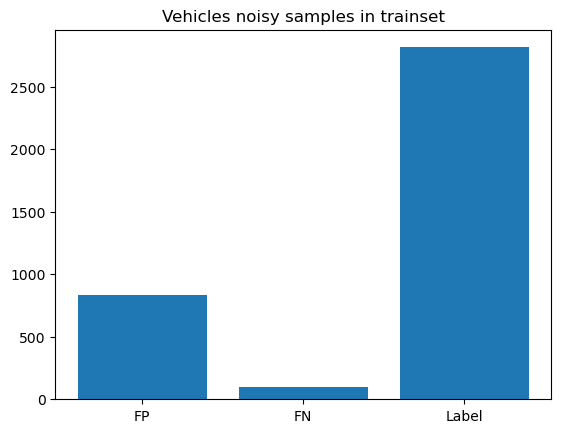

In [17]:
import matplotlib.pyplot as plt
plt.bar(range(3), [fp, fn, lab], tick_label = ['FP', 'FN', 'Label'])
plt.title('Vehicles noisy samples in trainset')

In [22]:
ms = 0
for pic_num in noise_label_info_moto_test:
    ms += noise_label_info_moto_test[pic_num]['problems'].count('ThreeBody')
fp, fn, lab = us.classify(noise_label_info_moto_test)
ms, fp, fn, lab

(166, 113, 20, 672)

### To detect the main problems in ThreeBody problems

In [65]:
import utils.showimg as ushow
from utils.label_mapping import NAME_ABBRE, LABEL_MAPPING
tt = 0
# target_threebody = []
# for pic_num in noise_label_info_moto:
#     problems = noise_label_info_moto[pic_num]['problems']
#     if 'ThreeBody' in problems:
#         target_threebody.append(pic_num)

# for pic_num in target_threebody:
#     gt_img = gt_data['labeling'][int(pic_num)]
#     for idx, anno in enumerate(gt_img["annotations"]):
#         xg, yg, wg, hg = anno['x'], anno['y'], anno['width'], anno['height'] #read the gt_box location
#         if 'hasRider' in anno.keys() and anno['hasRider'] == True and LABEL_MAPPING[anno['class']] in uc.moto_class and wg > sw and hg > sh:
#             for idx_oth, anno_oth in enumerate(gt_img['annotations']):
#                 if idx_oth == idx: continue;
#                 lxo, lyo, wo, ho = anno_oth['x'], anno_oth['y'], anno_oth['width'], anno_oth['height']
#                 cxo, cyo = lxo + wo / 2, lyo + ho / 2
#                 if xg <= cxo <= xg + wg + 10 and yg <= cyo <= yg + hg + 10:
#                     if (anno_oth['class'] in LABEL_MAPPING) and (NAME_ABBRE[anno_oth['class']] == 'car'):
#                         tt += 1
#                         ushow.generate_compare_images(pic_num, noise_label_info_moto, gt_data, pred_data, './checked_noise/threebody/train', train_prefix)
target_threebody = []
for pic_num in noise_label_info_moto_test:
    problems = noise_label_info_moto_test[pic_num]['problems']
    if 'ThreeBody' in problems:
        target_threebody.append(pic_num)

for pic_num in target_threebody:
    gt_img = gt_test_data['labeling'][int(pic_num)]
    for idx, anno in enumerate(gt_img["annotations"]):
        xg, yg, wg, hg = anno['x'], anno['y'], anno['width'], anno['height'] #read the gt_box location
        if 'hasRider' in anno.keys() and anno['hasRider'] == True and LABEL_MAPPING[anno['class']] in uc.moto_class and wg > sw and hg > sh:
            for idx_oth, anno_oth in enumerate(gt_img['annotations']):
                if idx_oth == idx: continue;
                lxo, lyo, wo, ho = anno_oth['x'], anno_oth['y'], anno_oth['width'], anno_oth['height']
                cxo, cyo = lxo + wo / 2, lyo + ho / 2
                if xg <= cxo <= xg + wg and yg <= cyo <= yg + hg:
                    if (anno_oth['class'] in LABEL_MAPPING) and (NAME_ABBRE[anno_oth['class']] == 'car'):
                        tt += 1
                        ushow.generate_compare_images(pic_num, noise_label_info_moto_test, gt_test_data, pred_test_data, './checked_noise/threebody/test', test_prefix)
tt

68

### Height // Width to filter the true people's bbox:

In [106]:
tt = 0
small_thres = 1.8
big_thres = 2.5
# for pic_num in noise_label_info_test:
#     problems = noise_label_info_test[pic_num]['problems']
#     for pblm in problems:
#         if 'ped' == pblm[-3:]:
#             index = problems.index(pblm)
#             invalid_index = noise_label_info_test[pic_num]['invalid_box_index'][index]
#             target_box = noise_label_info_test[pic_num]['bboxes_unnormalized'][invalid_index]
#             x, y, w, h = target_box
#             # print(pic_num, h / w)
#             # break
#             if small_thres <= h / w  and h / w <= big_thres:
#                 tt += 1
#                 ushow.generate_compare_images(pic_num, noise_label_info_test, gt_test_data, pred_test_data, './checked_noise/mislabeled_ped/test', test_prefix)
#                 break
for pic_num in noise_label_info:
    problems = noise_label_info[pic_num]['problems']
    for pblm in problems:
        if 'ped' == pblm[-3:]:
            index = problems.index(pblm)
            invalid_index = noise_label_info[pic_num]['invalid_box_index'][index]
            target_box = noise_label_info[pic_num]['bboxes_unnormalized'][invalid_index]
            x, y, w, h = target_box
            # print(pic_num, h / w)
            # break
            if small_thres <= h / w  and h / w <= big_thres:
                tt += 1
                ushow.generate_compare_images(pic_num, noise_label_info, gt_data, pred_data, './checked_noise/mislabeled_ped/threshold', train_prefix)
                break
tt

64

In [83]:
#To Calculate the statical number of height // width of all potential ped bbox in the dataset
ratio = 0
num = 0
for gt_img in gt_data['labeling']:
    for anno in gt_img['annotations']:
        if anno['class'] in LABEL_MAPPING and NAME_ABBRE[anno['class']] == 'ped':
            ratio += anno['height'] / anno['width']
            num += 1
ratio / num

2.3646297418153317

### Read the FN problems in train and test dataset

In [129]:
tt = 0
for pic_num in noise_label_info_test:
    problems = noise_label_info_test[pic_num]['problems']
    if 'FN' in problems:
        ushow.generate_compare_images(pic_num, noise_label_info_test, gt_test_data, pred_test_data, './checked_noise/transporters/test', test_prefix)
        tt += 1
        # gt_img = gt_data['labeling'][int(pic_num)]
        # for anno in gt_img['annotations']:
        #     #if [anno['x'], anno['y'], anno['width'], anno['height']] == target_box:
        #     if 'transporter' in anno.keys() and anno['transporter'] == True:
        #         ushow.generate_compare_images(pic_num, noise_label_info, gt_data, pred_data, './checked_noise/transporters/train', train_prefix)
        #         tt += 1
        #         break
tt

23

In [130]:
us.classify(noise_label_info_test)

(509, 23, 192)

In [134]:
for pic_num in noise_label_info_test:
    problems = noise_label_info_test[pic_num]['problems']
    if 'FP' in problems and problems.count('FP') >= 2:
        ushow.generate_compare_images(pic_num, noise_label_info_test, gt_test_data, pred_test_data, './checked_noise/random_generated/test', test_prefix)
        tt += 1

### Generate all noisy samples pics

In [136]:
for pic_num in noise_label_info_test:
    ushow.generate_compare_images(pic_num, noise_label_info_test, gt_test_data, pred_test_data, './checked_noise/overall/test', test_prefix)
for pic_num in noise_label_info:
    ushow.generate_compare_images(pic_num, noise_label_info, gt_data, pred_data, './checked_noise/overall/train', train_prefix)